In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_pacf
import seaborn as sns
from pyearth import Earth
from kats.consts import TimeSeriesData
from kats.models.prophet import ProphetModel, ProphetParams

import warnings
warnings.filterwarnings("ignore")

/Users/uditg/anaconda3/envs/myenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
energy_df = pd.read_csv('energy_cons.csv')
print(energy_df.shape)
energy_df.head()

(784, 19)


,Date,Data storage capacity,Data storage capacity added per day,Cumulative renewable energy purchases,Energy intensity lower bound,Energy intensity estimate,Energy intensity upper bound,Energy consumption rate lower bound,Energy consumption rate estimate,Energy consumption rate upper bound,Energy used to seal data lower bound,Energy used to seal data estimate,Energy used to seal data upper bound,Cumulative energy use lower bound,Cumulative energy use estimate,Cumulative energy use upper bound,Energy used to store data lower bound,Energy used to store data estimate,Energy used to store data upper bound
0,2020-08-24T00:00:00.000Z,498448,2053024,15734658.4700,1404.0981,10618.2456,21402.9825,651.8046,4929.1582,9935.6043,551.8939,3137.9856,5143.6463,15643.1789,118299.9113,238454.2728,0.4829,1.6056,4.3352
1,2020-08-25T00:00:00.000Z,9237744,13984256,16020743.1700,516.8322,3906.0165,7877.7548,4446.4727,33604.7076,67774.8419,3759.2477,21374.5158,35036.1550,122357.6233,924813.6787,1865048.9170,8.9495,29.7566,80.3434
2,2020-08-26T00:00:00.000Z,22553828,13212864,16306827.8700,200.7630,1514.9303,3059.6856,4217.0041,31820.9431,64268.3571,3551.8821,20195.4662,33103.5095,223564.8694,1688517.0540,3407488.0100,21.8501,72.6504,196.1574
3,2020-08-27T00:00:00.000Z,36361328,14277536,16592912.5700,134.9661,1017.1727,2056.6976,4570.5106,34445.6627,69648.2653,3838.0872,21822.7854,35770.9387,333256.2043,2515213.7590,5079044.7800,35.2269,117.1271,316.2454
4,2020-08-28T00:00:00.000Z,51427203,16174560,16878997.2700,108.3506,815.8238,1650.9771,5189.4841,39074.1396,79074.0694,4348.0452,24722.3297,40523.7426,457802.7809,3452994.0170,6976820.6400,49.8227,165.6573,447.2778


In [3]:
energy_df.loc[:, 'Date'] = energy_df.Date.apply(lambda x: datetime.strptime(x.split('T')[0], '%Y-%m-%d'))

energy_df.set_index('Date', inplace=True)

In [4]:
def get_pandas_df_with_datetime_index(start_date, end_date, y_list, column_name='y'):
    '''
    Helper function
    Input Date format: 'yyyy-mm-dd'
    '''
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    time_list = [(start_date + timedelta(days=x)) for x in range((end_date - start_date).days+1)]
    df = pd.DataFrame(y_list, index=time_list, columns=[column_name])
    return df

## Splitting the data into train and test sets

In [5]:
train_df = energy_df.iloc[:-30]
test_df = energy_df.iloc[-30:]   #Last 30 days as test set

# Modelling
## Regression Splines - Daily Storage Added

In [6]:
y_train = train_df.loc[:, 'Data storage capacity added per day']

dp = DeterministicProcess(index=y_train.index, order=1)
X_train = dp.in_sample()

In [7]:
model = Earth()
model.fit(X_train, y_train)

Earth()

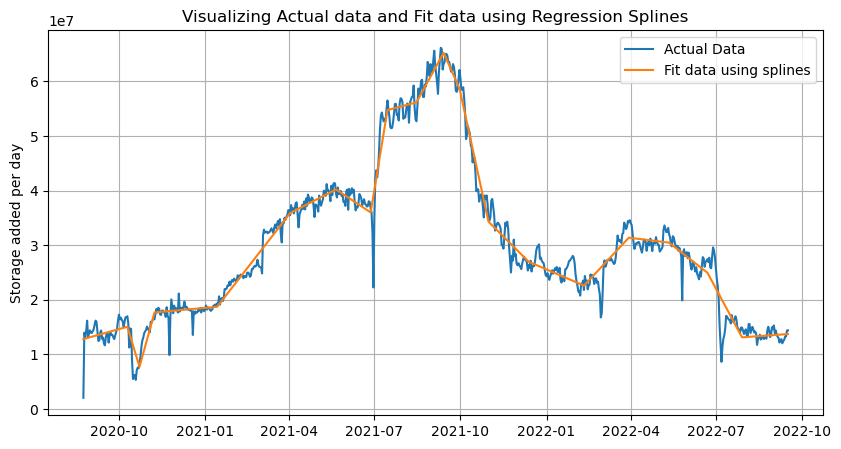

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(y_train.index, y_train, label='Actual Data')
ax.plot(y_train.index, model.predict(X_train), label='Fit data using splines')
ax.legend()
ax.grid()
ax.set_ylabel('Storage added per day')
ax.set_title('Visualizing Actual data and Fit data using Regression Splines');

The Residual Data is centered around 0 and looks like noise which occurs in any dynamic system.

### Predicting on last 30 days to see how well the algorithm works

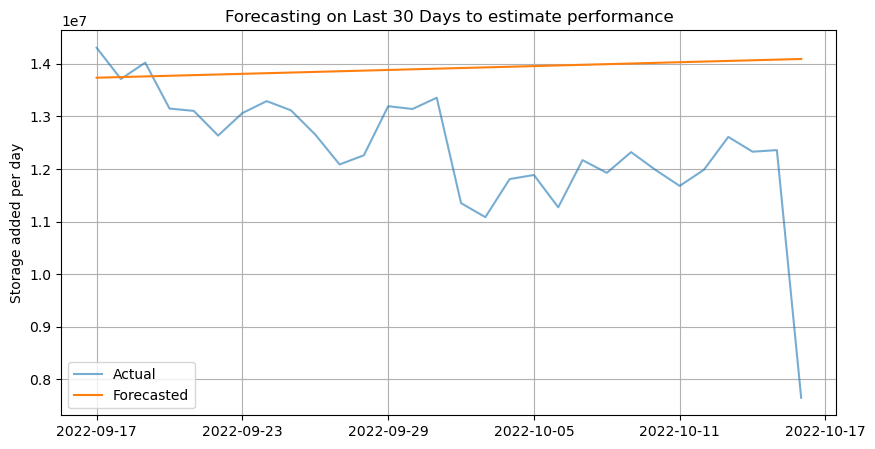

In [18]:
X_test = dp.out_of_sample(30)
y_fit = model.predict(X_test)
y_fit = get_pandas_df_with_datetime_index('2022-09-17', '2022-10-16', y_fit, column_name='y_test')

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(test_df.loc[:, 'Data storage capacity added per day'], alpha=0.6, label='Actual')
ax.plot(y_fit, label='Forecasted')
ax.set_title('Forecasting on Last 30 Days to estimate performance')
ax.set_ylabel('Storage added per day')
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.legend()
ax.grid()

In [19]:
#R2_score computation
ddf = pd.merge(y_fit, test_df.loc[:, 'Data storage capacity added per day'], left_index=True, right_index=True,
        how='inner')
r2_score(ddf.loc[:, 'Data storage capacity added per day'], ddf.loc[:, 'y_test'])

-1.8170735293686255

## Regression Splines - Cumulative Daily Storage added

In [20]:
y_train = train_df.loc[:, 'Data storage capacity added per day'].cumsum()

dp = DeterministicProcess(index=y_train.index, order=1)
X_train = dp.in_sample()

In [21]:
model = Earth()
model.fit(X_train, y_train)

Earth()

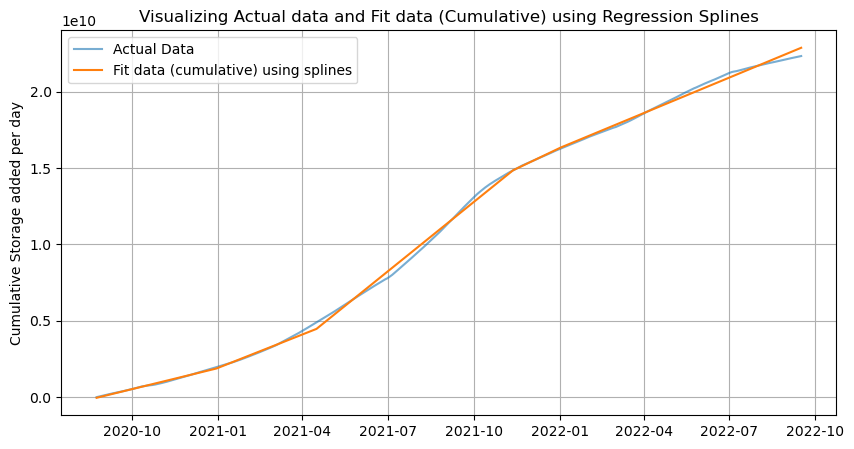

In [22]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(y_train.index, y_train, label='Actual Data', alpha=0.6)
ax.plot(y_train.index, model.predict(X_train), label='Fit data (cumulative) using splines')
ax.legend()
ax.grid()
ax.set_ylabel('Cumulative Storage added per day')
ax.set_title('Visualizing Actual data and Fit data (Cumulative) using Regression Splines');

### Predicting on last 30 days to see how well the algorithm works

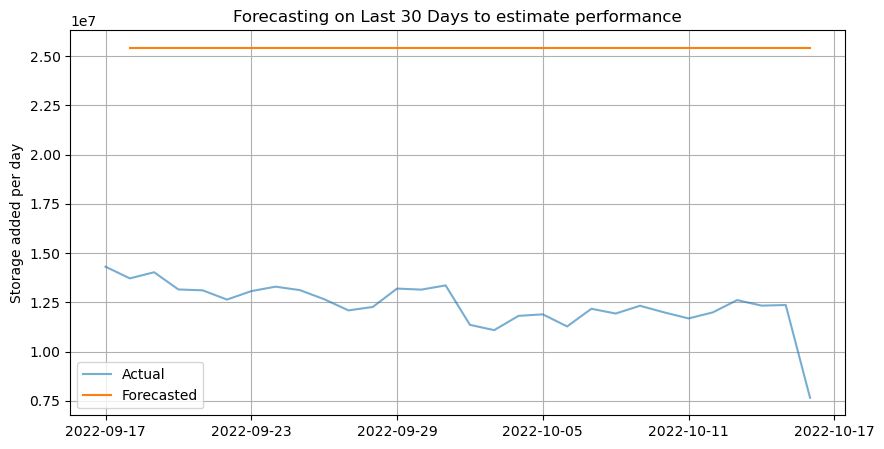

In [24]:
X_test = dp.out_of_sample(30)
y_fit = model.predict(X_test)
y_fit = get_pandas_df_with_datetime_index('2022-09-17', '2022-10-16', y_fit, column_name='y_test')

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(test_df.loc[:, 'Data storage capacity added per day'], alpha=0.6, label='Actual')

#Doing Diff to get daily values instead of cumulative
ax.plot(y_fit.diff(), label='Forecasted')
ax.set_title('Forecasting on Last 30 Days to estimate performance')
ax.set_ylabel('Storage added per day')
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.legend()
ax.grid()

In [25]:
#R2_score computation
ddf = pd.merge(y_fit.diff().dropna(), test_df.loc[:, 'Data storage capacity added per day'], left_index=True, right_index=True,
        how='inner')
r2_score(ddf.loc[:, 'Data storage capacity added per day'], ddf.loc[:, 'y_test'])

-131.80112329482816

## Prophet Model - Daily Storage Added

In [26]:
prophet_train_y = train_df.loc[:, 'Data storage capacity added per day']
prophet_ts_data = TimeSeriesData(time=train_df.index, value=prophet_train_y)
params = ProphetParams(seasonality_mode='multiplicative')
model = ProphetModel(prophet_ts_data, params)
model.fit()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -58.6226
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1927.51    0.00421283       144.273      0.6399      0.6399      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128        1935.2   0.000414287       268.876   2.665e-06       0.001      191  LS failed, Hessian reset 
     199       1940.14   0.000852636       83.1179           1           1      274   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1948.34    0.00170232       115.777      0.7626      0.7626      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     362       1950.65   0.000165751       145.788   8.122e-07       0.001      515  LS failed, Hessian reset 
     399        1951.2   6.61491e-05       52.5606      0.2509           1      561   
    Iter      log pro

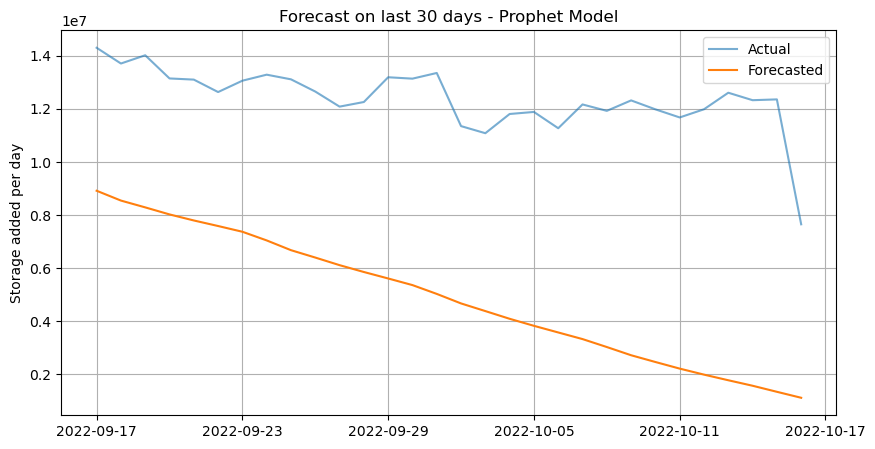

In [28]:
# make forecasts for test data
prophet_forecast = model.predict(steps=30, freq="D")
y_fit = get_pandas_df_with_datetime_index('2022-09-17', '2022-10-16', prophet_forecast.fcst.to_list(), column_name='y_test')

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(test_df.loc[:, 'Data storage capacity added per day'], alpha=0.6, label='Actual')
ax.plot(y_fit, label='Forecasted')
ax.set_title('Forecast on last 30 days - Prophet Model')
ax.set_ylabel('Storage added per day')
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.legend()
ax.grid()

In [29]:
ddf = pd.merge(y_fit, test_df.loc[:, 'Data storage capacity added per day'], left_index=True, right_index=True,
        how='inner')
r2_score(ddf.loc[:, 'Data storage capacity added per day'], ddf.loc[:, 'y_test'])

-41.95985306543381

## Prophet Model - Cumulative Daily Storage added

In [30]:
prophet_train_y = train_df.loc[:, 'Data storage capacity added per day'].cumsum()
prophet_ts_data = TimeSeriesData(time=train_df.index, value=prophet_train_y)
params = ProphetParams()
model = ProphetModel(prophet_ts_data, params)
model.fit()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.54599
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        4182.6     0.0248401       29758.9           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4715.89    0.00925623       47950.9      0.4706      0.4706      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4770.16    0.00043154       3252.02           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4894.14   0.000347506       6029.68           1           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4919.48   0.000358617       8666.75      0.4396      0.4396      571   
    Iter      log prob        ||dx||      ||grad||       alpha  

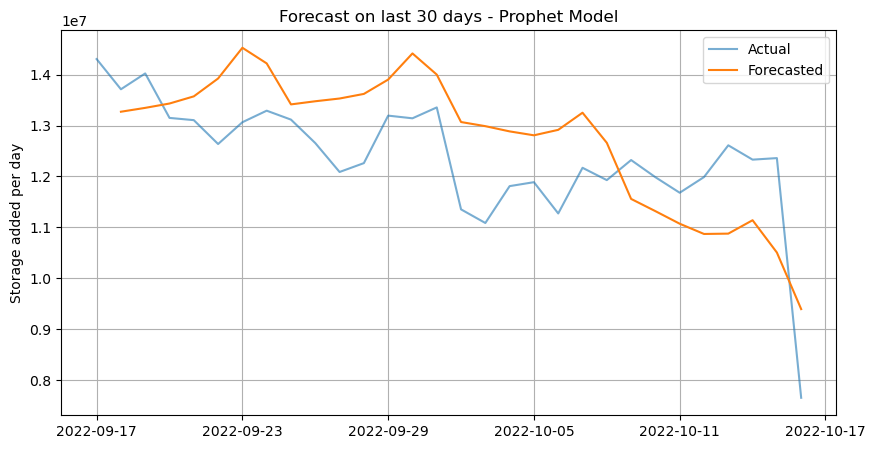

In [31]:
# make forecasts for test data
prophet_forecast = model.predict(steps=30, freq="D")
y_fit = get_pandas_df_with_datetime_index('2022-09-17', '2022-10-16', prophet_forecast.fcst.to_list(), column_name='y_test')

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(test_df.loc[:, 'Data storage capacity added per day'], alpha=0.6, label='Actual')
ax.plot(y_fit.diff(), label='Forecasted')
ax.set_title('Forecast on last 30 days - Prophet Model')
ax.set_ylabel('Storage added per day')
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.legend()
ax.grid()

In [32]:
ddf = pd.merge(y_fit.diff().dropna(), test_df.loc[:, 'Data storage capacity added per day'], left_index=True, right_index=True,
        how='inner')
r2_score(ddf.loc[:, 'Data storage capacity added per day'], ddf.loc[:, 'y_test'])

-0.04267594052606216

### Conclusion: Out of the 4 models, the Prophet Model to forecast 'Cumulative Storage added per day' is the best model. This model is used as the final Model to make forecasts for December

## Final Forecast for Decemeber Month using Prophet Model (Cumulative Storage added)

In [33]:
prophet_train_y = energy_df.loc[:, 'Data storage capacity added per day'].cumsum()
prophet_ts_data = TimeSeriesData(time=energy_df.index, value=prophet_train_y)
params = ProphetParams()
model = ProphetModel(prophet_ts_data, params)
model.fit()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.73771
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4389.05     0.0013689       5567.42      0.9456      0.9456      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4681.26    0.00044214       12177.9           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4853.47    0.00559942       16064.8           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4887.92    0.00276321       7734.36           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4931.25   9.81384e-06       7335.77      0.5835      0.5835      576   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [34]:
# make forecasts for test data
prophet_forecast = model.predict(steps=76, freq="D")
y_fit = get_pandas_df_with_datetime_index('2022-10-17', '2022-12-31', prophet_forecast.fcst.to_list(), 
                                          column_name='Data storage capacity added per day')

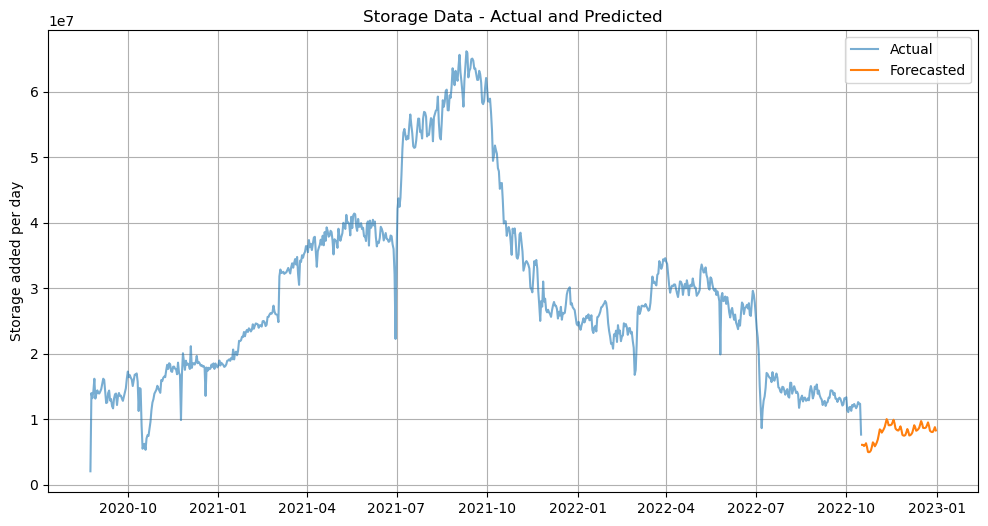

In [44]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.plot(energy_df.loc[:, 'Data storage capacity added per day'], alpha=0.6, label='Actual')
ax.plot(y_fit.diff().fillna(method='backfill'), label='Forecasted')
ax.set_ylabel('Storage added per day')
ax.set_title('Storage Data - Actual and Predicted')
ax.legend()
ax.grid()

# Final forecast for December

In [40]:
Daily_forecasted_value_December = y_fit.diff().iloc[-31:]

In [47]:
#Save to disk

#Daily_forecasted_value_December.to_csv('forecast_december.csv', index=True)

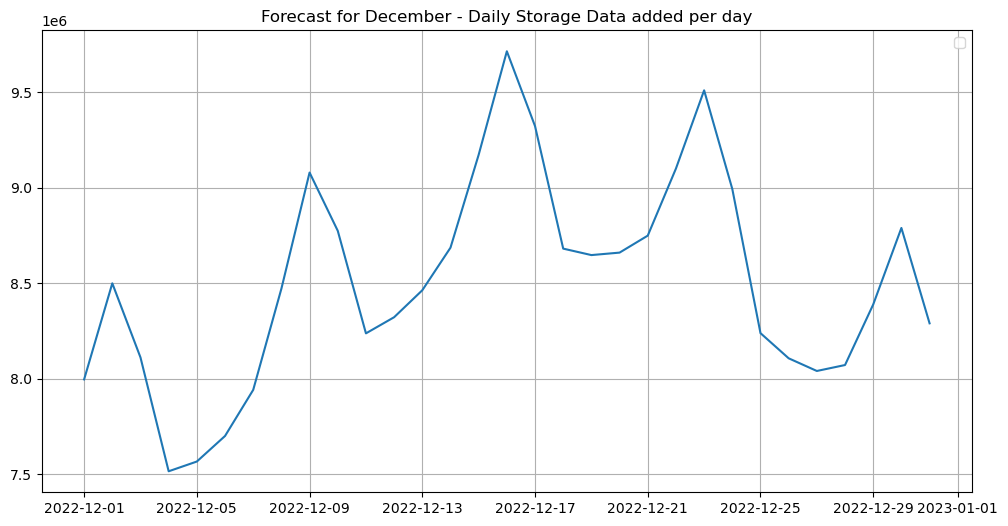

In [41]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.plot(Daily_forecasted_value_December)
ax.set_title('Forecast for December - Daily Storage Data added per day')
ax.legend()
ax.grid()